In [22]:
import torch
from torch import nn
from d2l import torch as d2l


In [23]:
net=nn.Sequential(
    nn.Conv2d(1,6,kernel_size=(5,5),padding=2),
    nn.Sigmoid(),
    nn.AvgPool2d((2,2),stride=2),
    nn.Conv2d(6,16,kernel_size=(5,5)),
    nn.Sigmoid(),
    nn.AvgPool2d((2,2),stride=2),
    nn.Flatten(),
    nn.Linear(16*5*5,120),
    nn.Sigmoid(),
    nn.Linear(120,84),
    nn.Sigmoid(),
    nn.Linear(84,10)
)

In [24]:
x=torch.randn((1,1,28,28),dtype=torch.float32)
for layer in net:
    x=layer(x)
    print(layer.__class__.__name__,'\t','output_shape\t',x.shape)

Conv2d 	 output_shape	 torch.Size([1, 6, 28, 28])
Sigmoid 	 output_shape	 torch.Size([1, 6, 28, 28])
AvgPool2d 	 output_shape	 torch.Size([1, 6, 14, 14])
Conv2d 	 output_shape	 torch.Size([1, 16, 10, 10])
Sigmoid 	 output_shape	 torch.Size([1, 16, 10, 10])
AvgPool2d 	 output_shape	 torch.Size([1, 16, 5, 5])
Flatten 	 output_shape	 torch.Size([1, 400])
Linear 	 output_shape	 torch.Size([1, 120])
Sigmoid 	 output_shape	 torch.Size([1, 120])
Linear 	 output_shape	 torch.Size([1, 84])
Sigmoid 	 output_shape	 torch.Size([1, 84])
Linear 	 output_shape	 torch.Size([1, 10])


## 训练模型（重点）
####    放到GPU中训练

In [42]:
batch_size=256
train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size=batch_size)
train_iter.num_workers=0
test_iter.num_workers=0

In [49]:
def eval_acc_gpu(net,data_iter,device=None):
    if isinstance(net,nn.Module):
        net.eval()
        if not device:
            device=next(iter(net.parameters())).device
    metric=d2l.Accumulator(2)
    with torch.no_grad():
        for X,y,in data_iter:
            if isinstance(X,list):
                X=[x.to(device) for x in X]
            else:
                X=X.to(device)
            y=y.to(device)
            metric.add(d2l.accuracy(net(X),y),y.numel())
    return metric[0]/metric[1]

In [78]:
def train_ch3(net,train_iter,test_iter,num_epoch,lr,device):
    def init_weight(m):
        if type(m)==nn.Linear or type(m)==nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weight)
    print(f'device is {device}')
    net.to(device)
    optimizer=torch.optim.SGD(net.parameters(),lr=lr)
    loss=nn.CrossEntropyLoss()
    animator=d2l.Animator(xlabel='epochs',xlim=[1,num_epochs],legend=['train_loss','train_acc','test_acc'])
    timer,num_batch=d2l.Timer(),len(train_iter)
    for epoch in range(num_epochs):
        metric=d2l.Accumulator(3)
        net.train()
        for i,(X,y) in enumerate(train_iter):
            timer.start()#训练开始
            optimizer.zero_grad()
            X=X.to(device)
            y=y.to(device)
            y_hat=net(X)
            l=loss(y_hat,y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l*X.shape[0],d2l.accuracy(y_hat,y),X.shape[0])
            timer.stop()#训练结束
            train_l=metric[0]/metric[2]
            train_acc=metric[1]/metric[2]
            if (i+1)%(num_batch//5)==0 or i==num_batch-1:
                animator.add(epoch+(i+1)/num_batch,(train_l,train_acc,None))
        test_acc=eval_acc_gpu(net,test_iter)
        animator.add(epoch+1,(None,None,test_acc))
    print(f'loss{train_l:.3f},train_acc{train_acc:.3f},test_acc{test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss0.418,train_acc0.846,test_acc0.824
23247.0 examples/sec on cuda:0


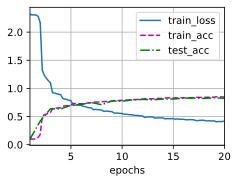

In [79]:
lr=0.5
num_epoch=20
train_ch3(net,train_iter,test_iter,num_epoch,lr,d2l.try_gpu())